In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries
import time
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score

import nltk

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

data = pd.read_csv(r"../../data/covtype.csv")
train_df = pd.read_csv(r"../../data/train.csv")
test_df = pd.read_csv(r"../../data/test.csv")

### Feature Engineering
# Drop "ID"
train_df = train_df.drop(columns=["Id"])

# Create Labels DF
train_labels_df = train_df[["Cover_Type"]]

# Drop Labels
train_df = train_df.drop(columns=["Cover_Type"])

# Build the np arrays
train_data = train_df.to_numpy()
test_data = test_df.drop(columns=["Id"]).to_numpy()
train_labels = train_labels_df.to_numpy().ravel()

# Shuffle the input
shuffle = np.random.permutation(np.arange(train_data.shape[0]))
train_data, train_labels = train_data[shuffle], train_labels[shuffle]

# Set some variables to hold dev, and training data.
dev_data, dev_labels = train_data[14000:], train_labels[14000:]
train_data, train_labels = train_data[:14000], train_labels[:14000]

## PCA

[0.7218959054455099, 0.9477491367462696, 0.9835319135851278, 0.9946008057018806, 0.9987227195142865, 0.9999996066709803, 0.99999988079987, 0.999999968812523, 0.9999999966860198, 0.9999999999999999]


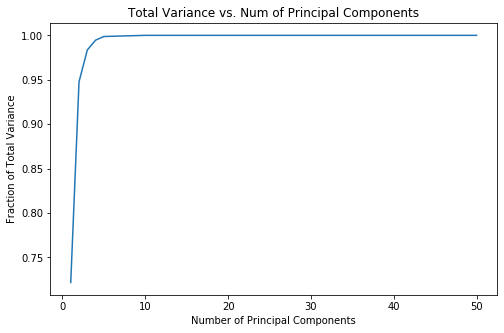

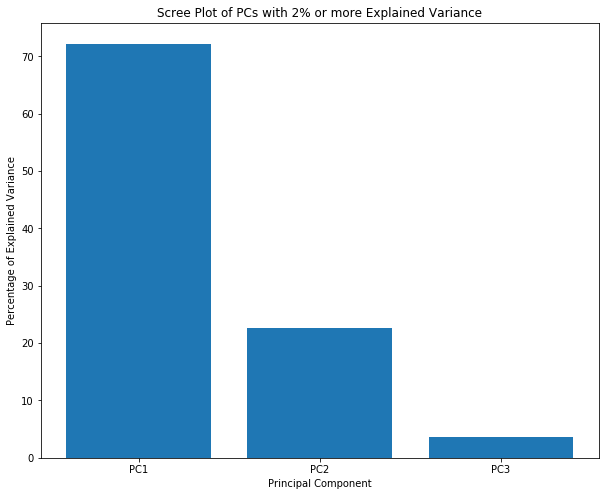

Top 10 features and their loading score influced on PC1:
--------------------------------------------------------
Horizontal_Distance_To_Roadways       0.812699
Horizontal_Distance_To_Fire_Points    0.554671
Elevation                             0.175417
Horizontal_Distance_To_Hydrology      0.032411
Hillshade_3pm                         0.004436
Hillshade_Noon                        0.003504
Aspect                                0.002003
Slope                                -0.001723
Hillshade_9am                         0.000678
Vertical_Distance_To_Hydrology        0.000557
dtype: float64


In [2]:
from sklearn.decomposition import PCA

def do_pca (t_data, n, k_principal_components):
    # Use PCA from sklearn and set number of components to the shape of the train_data feature size
    # Fit to the Train Data and get the variance ratio
    pca = PCA(n_components=n)
    pca.fit(t_data)
    explained_variance_ratio = pca.explained_variance_ratio_

    # Find only the prinicpal_components ratios
    total_variance = []
    for k in k_principal_components:
        total_variance_ratio = sum(explained_variance_ratio[0:k])
        total_variance.append(total_variance_ratio)

    print(total_variance)

    #Plot the total variance vs. number of principal components,
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(k_principal_components,total_variance)
    plt.ylabel("Fraction of Total Variance")
    plt.xlabel("Number of Principal Components")
    plt.title("Total Variance vs. Num of Principal Components")
    plt.show()  


    ##########################
    # Draw a scree plot
    #########################

    #The following code constructs the Scree plot
    per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
    per_var = per_var[per_var > 2]
    labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

    fig = plt.figure(figsize=(10,8))
    plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
    plt.ylabel('Percentage of Explained Variance')
    plt.xlabel('Principal Component')
    plt.title('Scree Plot of PCs with 2% or more Explained Variance')
    plt.show()

    #########################
    # Determine which feature had the biggest influence on PC1
    #########################
    ## first, get the loading scores
    loading_scores = pd.Series(pca.components_[0], index=train_df.columns)
    ## now sort the loading scores based on their magnitude
    sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
    ## get the names of the top 10 features
    top_10 = sorted_loading_scores[0:10].index.values
    ## print the gene names and their scores (and +/- sign)
    print("Top 10 features and their loading score influced on PC1:")
    print("--------------------------------------------------------")
    print(loading_scores[top_10])

    return

def print_importances(clf):
    importances = np.round(clf.feature_importances_,4)
    features = train_df.columns.to_numpy()
    importances_df = pd.DataFrame({'feature':features,'importance':importances})
    importances_df = importances_df.sort_values('importance',ascending=False)
    importances_df = importances_df[(importances_df.sum(axis=1) != 0)]  
    print(importances_df)

do_pca(train_data, 54, k_principal_components = [1,2,3,4,5,10,20,30,40,50])


### Feature Engineering

In [3]:
data = pd.read_csv(r"../../data/covtype.csv")
train_df = pd.read_csv(r"../../data/train.csv")
test_df = pd.read_csv(r"../../data/test.csv")

### Feature Engineering
# Drop "ID"
train_df = train_df.drop(columns=["Id"])

# Create Labels DF
train_labels_df = train_df[["Cover_Type"]]

# write labels to csv
train_labels_df.to_csv("train_labels.csv", index = False)

# Drop Labels
train_df = train_df.drop(columns=["Cover_Type"])

In [4]:
def convert_soil_types_to_categorical(df):

    df["SoilType"] = 0
    columns = list(df)

    for col_name in columns:
        soil_type = 0
        if col_name[0:9] == 'Soil_Type':
            soil_type = int(col_name[9:])
            df["SoilType"] = df["SoilType"] + df[col_name]*soil_type
            df = df.drop(columns=[col_name])
            
    return df          
            
def convert_wilderness_areas_to_categorical(df):

    df["WildernessArea"] = 0
    columns = list(df)

    for col_name in columns:
        wild_area = 0
        if col_name[0:15] == 'Wilderness_Area':
            wild_area = int(col_name[15:])
            df["WildernessArea"] = df["WildernessArea"] + df[col_name]*wild_area

    for col_name in columns:
        if col_name[0:15] == 'Wilderness_Area':
            df = df.drop(columns=[col_name])

    return df

train_df = convert_soil_types_to_categorical(train_df)
test_df = convert_soil_types_to_categorical(test_df)

train_df = convert_wilderness_areas_to_categorical(train_df)
test_df = convert_wilderness_areas_to_categorical(test_df)

train_df.to_csv("soil_wild_convert_train.csv", index = False)
test_df.to_csv("soil_wild_convert_test.csv", index = False)

print("Converted soil types and wilderness areas")

Converted soil types and wilderness areas


In [5]:
train_df = pd.read_csv(r"soil_wild_convert_train.csv")
test_df = pd.read_csv(r"soil_wild_convert_test.csv")

train_df['Average_Hillshade'] = ((train_df['Hillshade_9am']**2 +
                                 train_df['Hillshade_9am']**2 + train_df['Hillshade_9am']**2)/3)**0.5

test_df['Average_Hillshade'] = ((test_df['Hillshade_9am']**2 +
                                 test_df['Hillshade_9am']**2 + test_df['Hillshade_9am']**2)/3)**0.5

train_df = train_df.drop(columns=["Hillshade_9am"])
train_df = train_df.drop(columns=["Hillshade_Noon"])
train_df = train_df.drop(columns=["Hillshade_3pm"])
test_df = test_df.drop(columns=["Hillshade_9am"])
test_df = test_df.drop(columns=["Hillshade_Noon"])
test_df = test_df.drop(columns=["Hillshade_3pm"])

train_df.to_csv("hillshade_avg_convert_train.csv", index = False)
test_df.to_csv("hillshade_avg_convert_test.csv", index = False)

print("Converted Hillshade to average")

Converted Hillshade to average


In [6]:
train_df = pd.read_csv(r"hillshade_avg_convert_train.csv")
test_df = pd.read_csv(r"hillshade_avg_convert_test.csv")

train_df['Total_Distance_to_Hydrology'] = (train_df['Horizontal_Distance_To_Hydrology']**2 + 
                                           train_df['Vertical_Distance_To_Hydrology']**2)**0.5
test_df['Total_Distance_to_Hydrology'] = (test_df['Horizontal_Distance_To_Hydrology']**2 + 
                                          test_df['Vertical_Distance_To_Hydrology']**2)**0.5

train_df['Total_Distance_to_Hydrology'] = ((train_df['Total_Distance_to_Hydrology'] - train_df['Total_Distance_to_Hydrology'].min()) /
                (train_df['Total_Distance_to_Hydrology'].max() - train_df['Total_Distance_to_Hydrology'].min()))

test_df['Total_Distance_to_Hydrology'] = ((test_df['Total_Distance_to_Hydrology'] - test_df['Total_Distance_to_Hydrology'].min()) /
                 (test_df['Total_Distance_to_Hydrology'].max() - test_df['Total_Distance_to_Hydrology'].min()))


train_df = train_df.drop(columns=["Horizontal_Distance_To_Hydrology"])
train_df = train_df.drop(columns=["Vertical_Distance_To_Hydrology"])
test_df = test_df.drop(columns=["Horizontal_Distance_To_Hydrology"])
test_df = test_df.drop(columns=["Vertical_Distance_To_Hydrology"])

train_df.to_csv("total_distance_convert_train.csv", index = False)
test_df.to_csv("total_distance_convert_test.csv", index = False)

print("Converted Distance to Hydrology")

Converted Distance to Hydrology


In [7]:
train_df = pd.read_csv(r"total_distance_convert_train.csv")
test_df = pd.read_csv(r"total_distance_convert_test.csv")

train_df['Roadway_Distance_Normal'] = ((train_df['Horizontal_Distance_To_Roadways'] - train_df['Horizontal_Distance_To_Roadways'].min()) /
                (train_df['Horizontal_Distance_To_Roadways'].max() - train_df['Horizontal_Distance_To_Roadways'].min()))

test_df['Roadway_Distance_Normal'] = ((test_df['Horizontal_Distance_To_Roadways'] - test_df['Horizontal_Distance_To_Roadways'].min()) /
                 (test_df['Horizontal_Distance_To_Roadways'].max() - test_df['Horizontal_Distance_To_Roadways'].min()))

train_df = train_df.drop(columns=["Horizontal_Distance_To_Roadways"])
test_df = test_df.drop(columns=["Horizontal_Distance_To_Roadways"])

train_df['Fire_Points_Distance_Normal'] = ((train_df['Horizontal_Distance_To_Fire_Points'] - train_df['Horizontal_Distance_To_Fire_Points'].min()) /
                (train_df['Horizontal_Distance_To_Fire_Points'].max() - train_df['Horizontal_Distance_To_Fire_Points'].min()))

test_df['Fire_Points_Distance_Normal'] = ((test_df['Horizontal_Distance_To_Fire_Points'] - test_df['Horizontal_Distance_To_Fire_Points'].min()) /
                 (test_df['Horizontal_Distance_To_Fire_Points'].max() - test_df['Horizontal_Distance_To_Fire_Points'].min()))

train_df = train_df.drop(columns=["Horizontal_Distance_To_Fire_Points"])
test_df = test_df.drop(columns=["Horizontal_Distance_To_Fire_Points"])

train_df['Elevation_Normal'] = ((train_df['Elevation'] - train_df['Elevation'].min()) /
                (train_df['Elevation'].max() - train_df['Elevation'].min()))

test_df['Elevation_Normal'] = ((test_df['Elevation'] - test_df['Elevation'].min()) /
                 (test_df['Elevation'].max() - test_df['Elevation'].min()))

train_df = train_df.drop(columns=["Elevation"])
test_df = test_df.drop(columns=["Elevation"])

train_df.to_csv("distance_normal_train.csv", index = False)
test_df.to_csv("distance_normal_test.csv", index = False)

print("Converted all Distance/Elevation Measures to be Normal")

Converted all Distance/Elevation Measures to be Normal


In [8]:
train_df

,Aspect,Slope,SoilType,WildernessArea,Average_Hillshade,Total_Distance_to_Hydrology,Roadway_Distance_Normal,Fire_Points_Distance_Normal,Elevation_Normal
0,51,3,29,1,221.0,0.190134,0.074020,0.897898,0.369084
1,56,2,29,1,220.0,0.156296,0.056604,0.890176,0.366062
2,139,9,12,1,234.0,0.203229,0.461538,0.875304,0.473817
3,155,18,30,1,238.0,0.198414,0.448476,0.888174,0.464250
4,45,2,29,1,220.0,0.112756,0.056749,0.882597,0.368580
...,...,...,...,...,...,...,...,...,...
15115,243,23,4,3,170.0,0.190204,0.095791,0.183326,0.374622
15116,121,19,4,3,249.0,0.488124,0.089695,0.189475,0.372608
15117,134,25,4,3,250.0,0.282469,0.048621,0.169741,0.316717
15118,167,28,4,3,229.0,0.177060,0.035123,0.133276,0.314199


In [9]:
# Build the np arrays
train_data = train_df.to_numpy()
test_data = test_df.drop(columns=["Id"]).to_numpy()
train_labels = train_labels_df.to_numpy().ravel()

# Shuffle the input
shuffle = np.random.permutation(np.arange(train_data.shape[0]))
train_data, train_labels = train_data[shuffle], train_labels[shuffle]

# Set some variables to hold dev, and training data.
dev_data, dev_labels = train_data[14000:], train_labels[14000:]
train_data, train_labels = train_data[:14000], train_labels[:14000]

There are  9 features.
[0.9387579031761545, 0.9828863986537828, 0.9953507073782343, 0.9999355807548829, 0.9999940572871332, 0.9999966271536253, 0.9999983240960609, 0.9999993875965186]


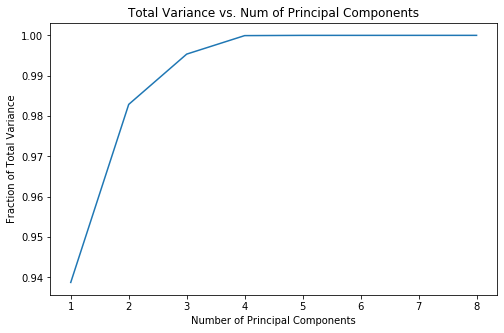

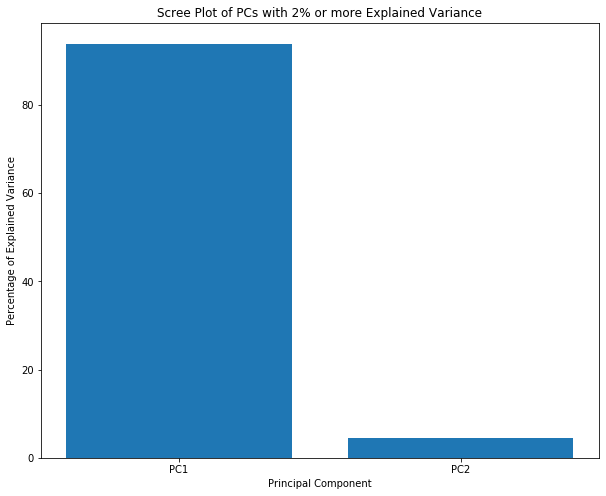

Top 10 features and their loading score influced on PC1:
--------------------------------------------------------
Aspect                         0.985628
Average_Hillshade             -0.168901
Slope                          0.002504
SoilType                      -0.001608
WildernessArea                 0.001319
Roadway_Distance_Normal        0.000104
Fire_Points_Distance_Normal   -0.000076
Total_Distance_to_Hydrology    0.000060
Elevation_Normal              -0.000030
dtype: float64


In [10]:
num_features = train_df.shape[1]
print("There are ", num_features, "features.")
do_pca(train_data, num_features, k_principal_components = [1,2,3,4,5,6,7,8])#,10,20,30,40,50])  

In [11]:
# knn_model = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
# knn_model.fit(train_data, train_labels)
# knn_predictions = knn_model.predict(test_data)
# weights = np.bincount(knn_predictions)[1:] / knn_predictions.shape[0]
# weights = dict(enumerate(weights.flatten(), 1))
# Save this method for hyper parameter tuning.... Andi

In [12]:
### Warning - this runs VERY slow with n_estimators at 1000 --> Changing to 100
ex = ExtraTreesClassifier(random_state=0, n_estimators = 100)
ex.fit(train_data, train_labels)
extra_trees_score = ex.score(dev_data, dev_labels)
print("Extra Trees Score: ", extra_trees_score)

print("Random Forest 10-Fold Cross Validation Scores: ")
extra_trees_cv_score = cross_val_score(ex, dev_data, dev_labels, cv = 10)
print(extra_trees_cv_score)
print("Mean: ", extra_trees_cv_score.mean())

print_importances(ex)

#### Baseline:
# Extra Trees Score:  0.86875
# [0.71428571 0.72321429 0.70535714 0.80357143 0.76785714 0.69642857 0.69642857 0.71428571 0.73214286 0.73214286]
# Mean:  0.7285714285714284 (Kaggle 0.75287)

### Turned Wilderness and SoilType into a category:
# Extra Trees Score:  0.875
# [0.75892857 0.75       0.73214286 0.80357143 0.75892857 0.75  0.70535714 0.70535714 0.72321429 0.76785714]
# Mean:  0.7455357142857142  (Kaggle 0.76396)

## Above + Calculating "Average Hillshade"
# Extra Trees Score:  0.8955357142857143
# [0.75       0.82142857 0.75892857 0.74107143 0.78571429 0.71428571  0.75892857 0.77678571 0.76785714 0.8125    ]
# Mean:  0.76875 (Kaggle 0.78105)

## Above + "Total Distance to Hydrology"
# Extra Trees Score:  0.8964285714285715
# [0.77678571 0.75892857 0.80357143 0.73214286 0.75       0.72321429  0.8125     0.77678571 0.77678571 0.78571429]
# Mean:  0.7696428571428571 (Kaggle 0.78188)


Extra Trees Score:  0.8839285714285714
Random Forest 10-Fold Cross Validation Scores: 
[0.75       0.72321429 0.71428571 0.78571429 0.78571429 0.75
 0.69642857 0.74107143 0.73214286 0.74107143]
Mean:  0.7419642857142856
                       feature  importance
8             Elevation_Normal      0.2439
2                     SoilType      0.1987
6      Roadway_Distance_Normal      0.1043
7  Fire_Points_Distance_Normal      0.0887
3               WildernessArea      0.0869
5  Total_Distance_to_Hydrology      0.0837
0                       Aspect      0.0733
4            Average_Hillshade      0.0665
1                        Slope      0.0541


In [13]:
ex_predictions = ex.predict(test_data)
predictions_ex = pd.DataFrame(data = ex_predictions, index = test_df.loc[:, "Id"], columns = ["Cover_Type"])
predictions_ex.to_csv("ex_predictions.csv")
print("Wrote Predictions File.")

Wrote Predictions File.
